<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter9_understanding_radial_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

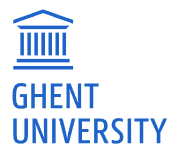<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 9: Understanding Axisymmetric Multilayer Well-Flow**

This Jupyter notebook implements the exact solution for axisymmetric flow to a pumping well extracting from a confined multilayer aquifer system (Hemker, 1985, 1999) and the approximate solution for large values of time developed in chapter 9 of my PhD thesis (Louwyck, 2023). The original code is written in Matlab, and consequently, the plots in chapter 9 are also created with Matlab. Here, two examples are given demonstrating the approximate solution is valid indeed for large values of time.

## Solutions

Import statements

In [1]:
from math import factorial, log
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy
from scipy.linalg import eig, inv, solve
from scipy.special import k0, exp1
import warnings
from scipy.linalg import LinAlgWarning
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt

Check versions:

In [2]:
# print("NumPy", np.__version__)
# print("Matplotlib", matplotlib.__version__)
# print("SciPy", scipy.__version__)

NumPy 1.23.5
Matplotlib 3.7.1
SciPy 1.10.1


Theis (1935) solution:

In [3]:
def theis(r, t, T, S, Q):
    t, r = np.meshgrid(t, r)
    u = r**2 * S / 4 / t / T
    return Q / 4 / np.pi / T * exp1(u)

Stehfest (1970) algorithm for numerical inversion of the Laplace transform:

In [4]:
def __fac(x):
    return float(factorial(x))

def Stehfest(F, t, ns=16):
    ns2 = ns // 2

    def W(j):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        w = 0
        for k in range(k_0, m + 1):
            w += k ** ns2 * __fac(2 * k) / __fac(ns2 - k) / __fac(k) / __fac(k - 1) / __fac(j - k) / __fac(2 * k - j)
        w *= (-1) ** (ns2 + j)
        return w

    ln2t = log(2) / t
    f = 0.
    for i in range(1, ns + 1):
        f = f + W(i) * F(i * ln2t)
    f = ln2t * f
    return f

Hemker's semi-analytical solution for axisymmetric flow to a pumping well in a confined multilayer system (Hemker, 1985, 1999):

In [5]:
class Hemker:

    def __init__(self, T, S, c, Q, ns=12):
        self.T = np.array(T)  # (nl, )
        self.nl = len(self.T) # int
        self.S = np.array(S)  # (nl, )
        self.c = np.array(c)  # (nl-1, )
        self.Q = np.array(Q)  # (nl, )
        self.ns = int(ns)
        self.no_warnings = True
        self._initialize()

    def _initialize(self):
        self._d = self.S / self.T  # (nl, )
        self._q = self.Q / 2 / np.pi / self.T  # (nl, )
        c = np.hstack((np.inf, self.c, np.inf))  # system is confined
        Tc1 = 1 / (self.T * c[:-1])  # (nl, )
        Tc2 = 1 / (self.T * c[1:])  # (nl, )
        self._idx = np.diag_indices(self.nl)
        irow, icol = self._idx
        self._A0 = np.zeros((self.nl, self.nl))  # (nl, nl)
        self._A0[irow, icol] = (Tc1 + Tc2).flatten()
        self._A0[irow[:-1], icol[:-1] + 1] = -Tc2.flatten()[:-1]
        self._A0[irow[:-1] + 1, icol[:-1]] = -Tc1.flatten()[1:]

    def _eig(self, p):
        A = self._A0.copy()  # (nl, nl)
        A[self._idx] += self._d.flatten() * p
        self._w, self._V = eig(A)  # (nl, ), (nl, nl)
        self._iV = inv(self._V)

    def _sp(self, r, p):
        self._eig(p)
        sw = np.sqrt(np.real(self._w))  # (nl, )
        b = np.dot(self._iV, self._q / p)  # (nl, )
        K = np.zeros((self.nl, self.nl))  # (nl, nl)
        K[self._idx] = k0(r * sw)
        return mdot((self._V, K, b))  # (nl, )

    def s(self, r, t):
        r, t = np.array(r), np.array(t)
        if r.ndim == 0: r = r[np.newaxis]
        if t.ndim == 0: t = t[np.newaxis]
        nr, nt = len(r), len(t)
        s = np.zeros((self.nl, nr, nt))
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
            for j, rj in enumerate(r):
                for k, tk in enumerate(t):
                    s[:, j, k] = Stehfest(lambda p: self._sp(rj, p), tk, self.ns).flatten()
            return s

The approximate solution for large values of time (Louwyck, 2023):

In [6]:
class Louwyck(Hemker):

    def __init__(self, T, S, c, Q, ns=12):
        super().__init__(T, S, c, Q, ns)

    def _initialize(self):
        super()._initialize()
        self._dtot = self.S.sum() / self.T.sum()
        # the approximate solution uses the corresponding steady-state eigenvalues and eigenvectors
        self._w0, self._V = eig(self._A0)  # (nl, ), (nl, nl)
        self._iz = np.argmin(np.abs(self._w0))
        self._iV = inv(self._V)  # (nl, nl)

    def _eig(self, p):
        self._w = self._w0.copy()  # (nl, )
        # the zero eigenvalue must be replaced by Stot/Ttot*p
        self._w[self._iz] = self._dtot * p

## Examples

### Example 1:

In [7]:
# input
T = [10, 100]     # transmissivities (m²/d)
S = [0.1, 0.001]  # storativities (-)
c = [100]         # vertical resistances (d)
Q = [50, 100]     # pumping rates (m³/d)

In [8]:
# models
m1 = Hemker(T=T, S=S, c=c, Q=Q)   # exact solution
m2 = Louwyck(T=T, S=S, c=c, Q=Q)  # approximate solution

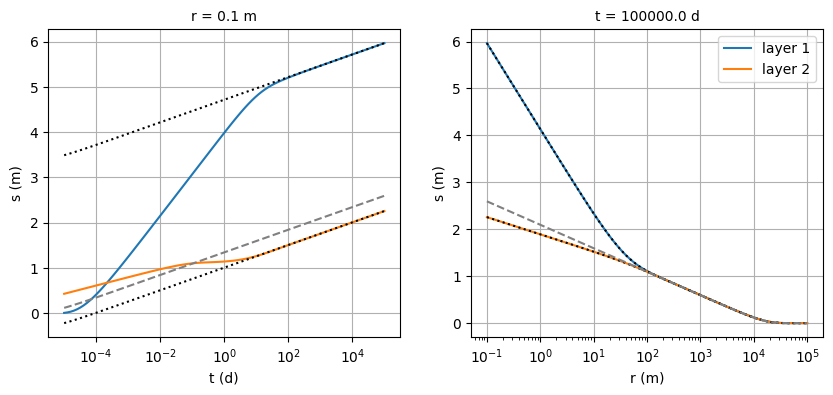

In [9]:
# plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# s vs t
r = 0.1  # distance (m)
t_series = np.logspace(-5, 5, 100)  # times (d)
ax1.semilogx(t_series, m1.s(r=r, t=t_series).squeeze().T, '-');
ax1.semilogx(t_series, m2.s(r=r, t=t_series).squeeze().T, 'k:');
s = theis(r=r, t=t_series, T=m1.T.sum(), S=m1.S.sum(), Q=m1.Q.sum())  # corresponding Theis solution
ax1.semilogx(t_series, s.T, color='gray', linestyle='--')
ax1.grid();
ax1.set_xlabel('t (d)');
ax1.set_ylabel('s (m)');
ax1.set_title(f'r = {r} m', dict(fontsize=10));

# s vs r
t = 1e5  # time (d)
r_series = np.logspace(-1, 5, 100)  # distances (m)
ax2.semilogx(r_series, m1.s(r=r_series, t=t).squeeze().T, '-');
ax2.legend(['layer 1', 'layer 2']);
ax2.semilogx(r_series, m2.s(r=r_series, t=t).squeeze().T, 'k:');
s = theis(r=r_series, t=t, T=m1.T.sum(), S=m1.S.sum(), Q=m1.Q.sum())  # corresponding Theis solution
ax2.semilogx(r_series, s, color='gray', linestyle='--')
ax2.grid();
ax2.set_xlabel('r (m)');
ax2.set_ylabel('s (m)');
ax2.set_title(f't = {t} d', dict(fontsize=10));

The colored solid lines are the exact solution (Hemker, 1999), the black dotted lines are the approximate solution (Louwyck, 2023). The corresponding Theis (1935) solution fpr the comprehensive one-layer system is represented by the gray dashed line.

According to Louwyck (2023), the approximate solution is valid if $t > 10Sc$, with $S$ and $c$ the sum of all storativities and resistances, resp.:

In [10]:
print(10 * m1.S.sum() * m1.c.sum())

101.0


We see the curves representing the exact and the approximate solution coincide indeed if $t$ is larger than 101 d.

### Example 2:

In [11]:
# input
T = [300, 100, 500, 200]          # transmissivities (m²/d)
S = [0.1, 0.001, 0.0005, 0.0001]  # storativities (-)
c = [100, 1000, 500]              # vertical resistances (d)
Q = [100, 0, 500, 20]             # pumping rates (m³/d)

In [12]:
# models
m1 = Hemker(T=T, S=S, c=c, Q=Q)   # exact solution
m2 = Louwyck(T=T, S=S, c=c, Q=Q)  # approximate solution

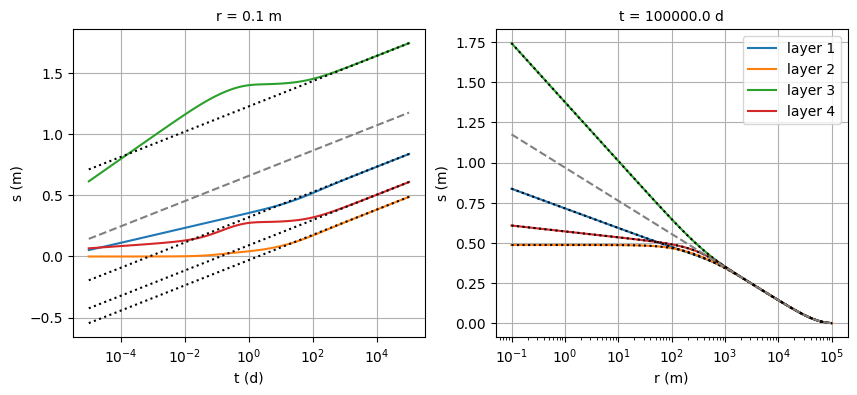

In [13]:
# plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# s vs t
r = 0.1  # distance (m)
t_series = np.logspace(-5, 5, 100)  # times (d)
ax1.semilogx(t_series, m1.s(r=r, t=t_series).squeeze().T, '-');
ax1.semilogx(t_series, m2.s(r=r, t=t_series).squeeze().T, 'k:');
s = theis(r=r, t=t_series, T=m1.T.sum(), S=m1.S.sum(), Q=m1.Q.sum())  # corresponding Theis solution
ax1.semilogx(t_series, s.T, color='gray', linestyle='--')
ax1.grid();
ax1.set_xlabel('t (d)');
ax1.set_ylabel('s (m)');
ax1.set_title(f'r = {r} m', dict(fontsize=10));

# s vs r
t = 1e5  # time (d)
r_series = np.logspace(-1, 5, 100)  # distances (m)
ax2.semilogx(r_series, m1.s(r=r_series, t=t).squeeze().T, '-');
ax2.legend([f'layer {i+1}' for i in range(m1.nl)]);
ax2.semilogx(r_series, m2.s(r=r_series, t=t).squeeze().T, 'k:');
s = theis(r=r_series, t=t, T=m1.T.sum(), S=m1.S.sum(), Q=m1.Q.sum())  # corresponding Theis solution
ax2.semilogx(r_series, s, color='gray', linestyle='--')
ax2.grid();
ax2.set_xlabel('r (m)');
ax2.set_ylabel('s (m)');
ax2.set_title(f't = {t} d', dict(fontsize=10));

Again, the colored solid lines are the exact solution (Hemker, 1999), the black dotted lines are the approximate solution (Louwyck, 2023). The corresponding Theis (1935) solution for the comprehensive one-layer system is represented by the gray dashed line.

Checking $t > 10Sc$:

In [14]:
print(10 * m1.S.sum() * m1.c.sum())

1625.6


We see the curves representing the exact and the approximate solution coincide indeed if $t$ is larger than 1625 d.

## References

- Hemker, C. J. (1985). Transient well flow in leaky multiple-aquifer systems. Journal of Hydrology, 81(1-2), 111-126. https://doi.org/10.1016/0022-1694(85)90170-2

- Hemker, C. J. (1999). Transient well flow in vertically heterogeneous aquifers. Journal of Hydrology, 225(1-2), 1-18. https://doi.org/10.1016/S0022-1694(99)00137-7

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47-49. https://doi.org/10.1145/361953.361969

- Theis, C. V. (1935). The relation between the lowering of the piezometric surface and the rate and duration of discharge of a well using ground-water storage. Transactions, American Geophysical Union, 16(2), 519-524. https://doi.org/10.1029/TR016i002p00519

---